In [1]:
# loading modules
import ee
import geemap
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# initialize ee 
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score


# import all FMSE py functions 
from FMSE import *


## Area of Interest

### a) Through filtering ADM2 boundaries

In [3]:
# CASE 1: Pakistan Floods 2022

city = 'Shikarpur'
city_shp = ee.FeatureCollection('projects/earthengine-legacy/assets/projects/sat-io/open-datasets/geoboundaries/CGAZ_ADM2')\
    .filter(ee.Filter.eq('shapeName', city))


aoi = boundary(city_shp)

# Shikarpur

startDate = ee.Date('2022-03-01')
endDate = ee.Date('2022-08-01')
predays = 60
postdays = 30

# optional
split = 0.8
zvv_value = -3
zvh_value = -3
water_value = 75
elev_value = 900
slope_value = 15
num_samples = 1000
under_estimate = False

# print coordinates of aoi
#print(aoi.coordinates().getInfo())


In [2]:
# Case 2: Sylhet, Bangladesh Floods 2022

city = 'Sylhet'
city_shp = ee.FeatureCollection("projects/sat-io/open-datasets/geoboundaries/CGAZ_ADM2")\
    .filter(ee.Filter.eq('shapeName', city))


aoi = boundary(city_shp)


# Shikarpur

startDate = ee.Date('2022-01-01')
endDate = ee.Date('2022-05-17')
predays = 60
postdays = 10

# optional
split = 0.8
zvv_value = -3
zvh_value = -3
water_value = 75
elev_value = 900
slope_value = 15
num_samples = 1000
under_estimate = False

#print(aoi.coordinates().getInfo())

In [2]:
# 1 Iberville Parish
# 2 East Baton Rouge Parish

# Case 3: USA Floods 2016

city = 'Iberville'
city_shp = ee.FeatureCollection('projects/earthengine-legacy/assets/projects/sat-io/open-datasets/geoboundaries/CGAZ_ADM2')\
    .filter(ee.Filter.eq('shapeName', 'Iberville Parish'))


aoi = boundary(city_shp)


# Shikarpur

startDate = ee.Date('2016-01-01')
endDate = ee.Date('2016-08-09')
predays = 60
postdays = 20

# optional
split = 0.8
zvv_value = -3
zvh_value = -3
water_value = 75
elev_value = 900
slope_value = 15
num_samples = 1000
under_estimate = False


#print(aoi.coordinates().getInfo())


In [4]:
# Case 4: Ernakulam, Kerala, India Floods 2018

city = 'Ernakulam'
city_shp = ee.FeatureCollection('projects/earthengine-legacy/assets/projects/sat-io/open-datasets/geoboundaries/CGAZ_ADM2')\
    .filter(ee.Filter.eq('shapeName', city))


aoi = boundary(city_shp)


# Shikarpur

startDate = ee.Date('2018-03-01')
endDate = ee.Date('2018-08-07')
predays = 60
postdays = 20

# optional
split = 0.8
zvv_value = -3
zvh_value = -3
water_value = 75
elev_value = 900
slope_value = 15
num_samples = 1000
under_estimate = False


#print(aoi.coordinates().getInfo())


[[[76.16997176590127, 9.788556224718201], [76.83038245383979, 9.788556224718201], [76.83038245383979, 10.301696219489859], [76.16997176590127, 10.301696219489859], [76.16997176590127, 9.788556224718201]]]


## Flood layer Masking

In [3]:
# Fetching pre and post-flood images
s1_pre = get_s1_col(startDate, predays, aoi).select(['VV', 'VH'])
s1_post = get_s1_col(endDate, postdays, aoi).select(['VV', 'VH'])

print('Images in S1 Pre: ', s1_pre.size().getInfo())
print('Images in S1 Post: ', s1_post.size().getInfo())

# Calculate Z-score
zscore = calculate_zscore(s1_pre, s1_post, aoi)

# Generate flood masks
flood_class, flood_layer = map_floods(zscore, aoi, zvv_value, zvh_value, water_value, elev_value, slope_value, under_estimate)

print('Done with flood masking...')

Images in S1 Pre:  17
Images in S1 Post:  4
Done with flood masking...


In [4]:
# Run flood mapping example
flood_binary = flood_mapping(aoi, s1_post, flood_layer, num_samples, split, city)
print('Done with flood mapping...')

Done with preparing datasets...
Done with creating sample feature collection...
Done with creating training and validation samples...
Done with classification...
Flood Mapping Accuracy Results:                     0
accuracy        0.57
precision       0.58
recall          0.50
f1_score        0.54
precision_mean  0.57
recall_mean     0.57
f1_mean         0.57
Done ...
Done with flood mapping...


In [5]:
# Run susceptibility analysis example
flood_susceptibility_prob = susceptibility_analysis(aoi, endDate, flood_binary, num_samples, split, city)
sus_catagory = quantile_based_categorization(flood_susceptibility_prob, aoi)

flood_susceptibility_prob = flood_susceptibility_prob.clip(city_shp)
flood_binary = flood_binary.clip(city_shp)
sus_catagory = sus_catagory.clip(city_shp)

Done with preparing datasets for susceptibility analysis...
Bands for susceptibility analysis: ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'NDVI', 'NDWI', 'NDBI', 'elevation', 'slope', 'aspect']
Flood Susceptibility Mapping Accuracy Results:                     0
accuracy        0.77
precision       0.82
recall          0.74
f1_score        0.78
precision_mean  0.78
recall_mean     0.78
f1_mean         0.78


### Visualize Data on the Map

In [6]:
Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(city_shp, {}, 'City Boundaries')
Map.addLayer(aoi, {}, 'AOI Boundary')
Map.addLayer(flood_class.clip(city_shp), {'min': 0, 'max': 4, 'palette': ['#FFFFFF','#FFA500','#FFFF00','#FF0000','#0000FF']}, 'Flood class')# non-flooded, vv, vh, vv+vh, water
Map.addLayer(flood_layer.clip(city_shp), {'min': 1, 'max': 2, 'palette': ['blue', 'white']}, 'Flood layer')
Map.addLayer(flood_binary, {'min': 1, 'max': 2, 'palette': ['blue', 'white']}, 'Flood Binary')
Map.addLayer(flood_susceptibility_prob, {'min': 0.1, 'max': 0.9, 'palette': ['#1a9641', '#a6d96a', '#ffffbf', '#fdae61', '#d7191c']}, 'Flood Susceptibility')

Map.addLayer(sus_catagory, {'min': 1, 'max': 5, 'palette': ['#1a9641', '#a6d96a', '#ffffbf', '#fdae61', '#d7191c']}, 'Flood Susceptibility Categorical')
Map

Map(center=[24.891039839242318, 92.06797579751841], controls=(WidgetControl(options=['position', 'transparent_…

### Model Tuning Optional

In [7]:
import time


s1_post = s1_post
flood_layer = flood_layer
aoi = aoi



def update_feature(feature):
    value = feature.get('label')
    updated_value = ee.Algorithms.If(ee.Algorithms.IsEqual(value, ee.Number(2)), ee.Number(0), value)
    return feature.set('label', updated_value)
bands = ['VV', 'VH', 'elevation']#, 'slope', 'aspect', 'dtriver']

def prepare_datasets(aoi, projection='EPSG:4326', scale=30):
    """
    Prepare DEM, slope, and aspect datasets.

    Parameters:
    aoi (ee.Geometry): Area of Interest.
    projection (str): Projection to reproject the images. Default is 'EPSG:4326'.
    scale (int): Scale for reprojection. Default is 30.

    Returns:
    tuple: DEM, slope, aspect, and dtriver images reprojected to the specified projection.
    """
    dem_proj = ee.ImageCollection("projects/sat-io/open-datasets/FABDEM")\
        .filterBounds(aoi)\
        .mosaic()\
        .clip(aoi)\
        .setDefaultProjection('EPSG:3857', None, 30)

    slope_proj = ee.Terrain.slope(dem_proj)
    aspect_proj = ee.Terrain.aspect(dem_proj)

    dem = dem_proj.reproject(crs=projection, scale=scale)
    slope = slope_proj.reproject(crs=projection, scale=scale)
    aspect = aspect_proj.reproject(crs=projection, scale=scale)
    
    shoreline = ee.FeatureCollection('projects/sat-io/open-datasets/shoreline/mainlands')\
        .merge(ee.FeatureCollection('projects/sat-io/open-datasets/shoreline/big_islands'))\
        .filterBounds(aoi)
    
    rivers = ee.FeatureCollection("projects/sat-io/open-datasets/HydroAtlas/RiverAtlas_v10")\
        .filterBounds(aoi)

    # Combine rivers and shoreline into a single FeatureCollection
    rivers_and_shoreline = rivers.merge(shoreline)

    # Generate distance rasters for roads, and rivers+shoreline
    dtriver = distance_to_feature(rivers_and_shoreline, projection, scale, aoi)
    #rivers_and_shoreline_distance = distance_to_feature(rivers_and_shoreline, 30)

    return dem.rename('elevation'), slope, aspect, dtriver.rename('dtriver')


def prepare_samples(flood_layer, num_samples, aoi, scale=10, split=0.8):
    sample = flood_layer.stratifiedSample(
        numPoints=num_samples,
        classBand='label',
        region=aoi,
        scale=scale,
        seed=5,
        tileScale=1.5,
        geometries=True
    )
    label = sample.map(update_feature)

    image = s1_post.mean().clip(aoi).toFloat()
    
    dem, slope, aspect, dtriver = prepare_datasets(aoi, scale=30)
    
    image = image.addBands(dem)#.addBands(slope).addBands(aspect).addBands(dtriver)
    sample_all = image.sampleRegions(
        collection=label,
        properties=['label'],
        scale=scale
    ).randomColumn()

    training = sample_all.filter(ee.Filter.lt('random', split))
    validation = sample_all.filter(ee.Filter.gte('random', split))
    return image, training, validation

def evaluate_classifier(classifier, training, validation):
    start_time = time.time()
    
    trained_classifier = classifier.train(
        features=training,
        classProperty='label',
        inputProperties=bands
    )
    
    training_classified = training.classify(trained_classifier)
    validation_classified = validation.classify(trained_classifier)
    
    training_accuracy = training_classified.errorMatrix('label', 'classification')
    validation_accuracy = validation_classified.errorMatrix('label', 'classification')
    
    end_time = time.time()
    prediction_time = end_time - start_time
    
    return {
        'train_f1': training_accuracy.fscore().getInfo()[1] if len(training_accuracy.fscore().getInfo()) > 1 else None,
        'validation_f1': validation_accuracy.fscore().getInfo()[1] if len(validation_accuracy.fscore().getInfo()) > 1 else None,
        'train_producer_accuracy': training_accuracy.producersAccuracy().getInfo()[1] if len(training_accuracy.producersAccuracy().getInfo()) > 1 else None,
        'validation_producer_accuracy': validation_accuracy.producersAccuracy().getInfo()[1] if len(validation_accuracy.producersAccuracy().getInfo()) > 1 else None,
        'train_consumer_accuracy': training_accuracy.consumersAccuracy().getInfo()[1] if len(training_accuracy.consumersAccuracy().getInfo()) > 1 else None,
        'validation_consumer_accuracy': validation_accuracy.consumersAccuracy().getInfo()[1] if len(validation_accuracy.consumersAccuracy().getInfo()) > 1 else None,
        'prediction_time': prediction_time
    }

def compare_models(flood_layer, s1_post, aoi, num_samples=1000, split=0.8):
    
    image, training, validation = prepare_samples(flood_layer, num_samples, aoi, scale=10, split=split)
    bands = image.bandNames().getInfo()
    print(bands)
    classifiers = {
        'RandomForest': ee.Classifier.smileRandomForest(100),
        'GradientTreeBoost': ee.Classifier.smileGradientTreeBoost(50),
        'DecisionTree': ee.Classifier.smileCart(),
        'SVM': ee.Classifier.libsvm()
    }

    results = {}
    for name, classifier in classifiers.items():
        print(f"Evaluating {name} classifier...")
        results[name] = evaluate_classifier(classifier, training, validation)
    
    for name, metrics in results.items():
        print(f"\nClassifier: {name}")
        print(f"Training F1 Score: {metrics['train_f1']}")
        print(f"Validation F1 Score: {metrics['validation_f1']}")
        print(f"Training Producer Accuracy: {metrics['train_producer_accuracy'][0]}")
        print(f"Validation Producer Accuracy: {metrics['validation_producer_accuracy'][0]}")
        print(f"Training Consumer Accuracy: {metrics['train_consumer_accuracy']}")
        print(f"Validation Consumer Accuracy: {metrics['validation_consumer_accuracy']}")
        print(f"Prediction Time: {metrics['prediction_time']} seconds")

    return results

# Example usage
results = compare_models(flood_layer, s1_post, aoi, num_samples=1000, split=0.8)

# results to df

models_compare_df = pd.DataFrame(results).T
models_compare_df.reset_index(inplace=True)
models_compare_df.rename(columns={'index': 'Model'}, inplace=True)
models_compare_df = models_compare_df.round(2)
models_compare_df.to_csv(f'{city}_all_models_compare_df.csv', index=False)
models_compare_df


['VV', 'VH', 'elevation']
Evaluating RandomForest classifier...
Evaluating GradientTreeBoost classifier...
Evaluating DecisionTree classifier...
Evaluating SVM classifier...

Classifier: RandomForest
Training F1 Score: 0.9795412275263484
Validation F1 Score: 0.835820895522388
Training Producer Accuracy: 0.9825870646766169
Validation Producer Accuracy: 0.8571428571428571
Training Consumer Accuracy: None
Validation Consumer Accuracy: None
Prediction Time: 0.0003077983856201172 seconds

Classifier: GradientTreeBoost
Training F1 Score: 0.9224084419615146
Validation F1 Score: 0.8279301745635911
Training Producer Accuracy: 0.9241293532338308
Validation Producer Accuracy: 0.8469387755102041
Training Consumer Accuracy: None
Validation Consumer Accuracy: None
Prediction Time: 0.0013298988342285156 seconds

Classifier: DecisionTree
Training F1 Score: 1
Validation F1 Score: 0.7864077669902914
Training Producer Accuracy: 1
Validation Producer Accuracy: 0.826530612244898
Training Consumer Accuracy:

,Model,train_f1,validation_f1,train_producer_accuracy,validation_producer_accuracy,train_consumer_accuracy,validation_consumer_accuracy,prediction_time
0,RandomForest,0.979541,0.835821,[0.9825870646766169],[0.8571428571428571],None,None,0.000308
1,GradientTreeBoost,0.922408,0.82793,[0.9241293532338308],[0.8469387755102041],None,None,0.00133
2,DecisionTree,1,0.786408,[1],[0.826530612244898],None,None,0.00041
3,SVM,0.869018,0.84131,[0.8582089552238806],[0.8520408163265306],None,None,0.000581


Evaluated RandomForest with 10 trees: F1 Score = 0.8261964735516372
Evaluated RandomForest with 20 trees: F1 Score = 0.8312342569269522
Evaluated RandomForest with 30 trees: F1 Score = 0.8329177057356608
Evaluated RandomForest with 40 trees: F1 Score = 0.8370927318295739
Evaluated RandomForest with 50 trees: F1 Score = 0.8329177057356608
Evaluated RandomForest with 60 trees: F1 Score = 0.8349999999999999
Evaluated RandomForest with 70 trees: F1 Score = 0.835820895522388
Evaluated RandomForest with 80 trees: F1 Score = 0.835820895522388
Evaluated RandomForest with 90 trees: F1 Score = 0.8379052369077307
Evaluated RandomForest with 100 trees: F1 Score = 0.835820895522388
Evaluated RandomForest with 110 trees: F1 Score = 0.8421052631578947
Evaluated RandomForest with 120 trees: F1 Score = 0.8379052369077307
Evaluated RandomForest with 130 trees: F1 Score = 0.8329177057356608
Evaluated RandomForest with 140 trees: F1 Score = 0.8308457711442786
Evaluated RandomForest with 150 trees: F1 Scor

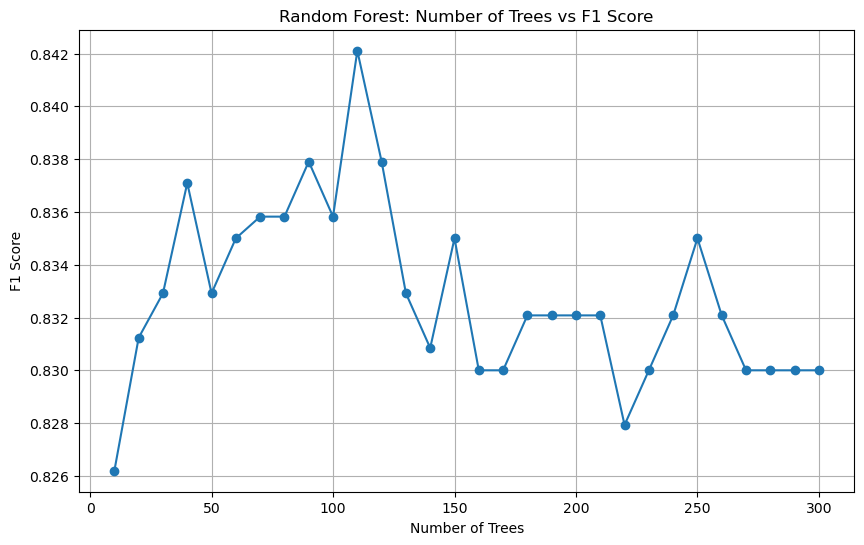

,Number of Trees,F1 Score
0,10,0.83
1,20,0.83
2,30,0.83
3,40,0.84
4,50,0.83
5,60,0.83
6,70,0.84
7,80,0.84
8,90,0.84
9,100,0.84


In [8]:
import matplotlib.pyplot as plt

def evaluate_rf_trees(training, validation, bands, num_trees_list):
    results = {}
    
    for num_trees in num_trees_list:
        classifier = ee.Classifier.smileRandomForest(num_trees).train(
            features=training,
            classProperty='label',
            inputProperties=bands
        )
        
        validation_classified = validation.classify(classifier)
        validation_accuracy = validation_classified.errorMatrix('label', 'classification')
        f1_score = validation_accuracy.fscore().getInfo()[1] if len(validation_accuracy.fscore().getInfo()) > 1 else None
        
        results[num_trees] = f1_score
        print(f"Evaluated RandomForest with {num_trees} trees: F1 Score = {f1_score}")
    
    return results

new_trees = list(range(10, 310, 10))# 10 to 300 trees in steps of 10
def fine_tune_rf_trees(flood_layer, s1_post, aoi, num_samples=200, split=0.8, num_trees_list=new_trees):
    if num_trees_list is None:
        num_trees_list = [10, 50, 100, 150, 200, 250, 300]

    
    image, training, validation = prepare_samples(flood_layer, num_samples, aoi, scale=10, split=split)
    bands = image.bandNames().getInfo()
    results = evaluate_rf_trees(training, validation, bands, num_trees_list)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.xlabel('Number of Trees')
    plt.ylabel('F1 Score')
    plt.title('Random Forest: Number of Trees vs F1 Score')
    plt.grid(True)
    plt.savefig(f'{city}_rf_trees_f1_score.png', dpi=300, bbox_inches='tight', pad_inches=0.1, transparent=True)
    plt.show()
    
    return results

# Example usage
results_rf_trees = fine_tune_rf_trees(flood_layer, s1_post, aoi, num_samples=1000, split=0.8)
# save df results_rf_trees to csv
results_rf_trees_df = pd.DataFrame(results_rf_trees, index=[0]).T
results_rf_trees_df.reset_index(inplace=True)
results_rf_trees_df.rename(columns={'index': 'Number of Trees', 0: 'F1 Score'}, inplace=True)
results_rf_trees_df.to_csv(f'{city}_rf_trees_f1_score_df.csv', index=False)
results_rf_trees_df


# Exposure Analysis

## A) Exposure to Flood Hazard

### Population Exposed to Floods

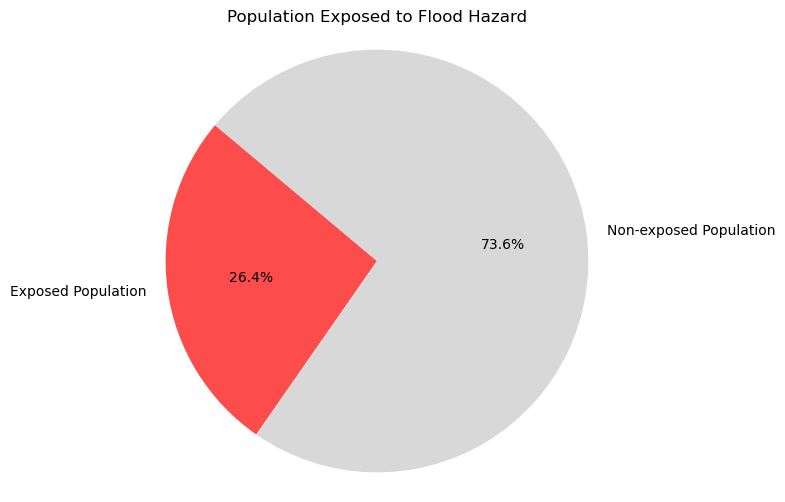

Total population: 37872
Population exposed to flood hazard: 10011


In [9]:
total_exposed_population, total_population = calculate_flood_exposure(flood_binary, city_shp.geometry())

# print total population without decimal points
print('Total population:', int(total_population.getInfo()))
print('Population exposed to flood hazard:', int(total_exposed_population.getInfo()))


### Population Exposed to flood hazard OR Susceptibility Levels

In [10]:
# Calculate exposure dataframe

# unccomment below for exposure due to flood hazard calculation
#exposure_df = calculate_exposure_df(flood_binary, aoi, flood_map=True)

# import all FMSE py functions 


exposure_df = calculate_exposure_df(sus_catagory, city_shp.geometry(), flood_map=False, export=False)

exposure_df.to_csv(f'{city}_exposure_df.csv', index=False)
print(exposure_df)


   Susceptibility Level   Category  Exposed Population  \
0                     1   Very Low             2093.13   
1                     2        Low             7050.04   
2                     3   Moderate             8328.70   
3                     4       High             8358.88   
4                     5  Very High            12389.35   

   Exposed Nighttime Light  lulc_water  lulc_trees  lulc_flooded_vegetation  \
0                    99.25        1.71      145.12                        0   
1                   336.22       17.59       96.85                        0   
2                   234.24       33.53       86.35                        9   
3                   236.67       52.83       44.75                       11   
4                   292.35       80.77       36.50                       21   

   lulc_crops  lulc_built_area  lulc_bare_ground  lulc_snow_ice  lulc_clouds  \
0       15.95            39.36              0.00              0            0   
1      175.53   

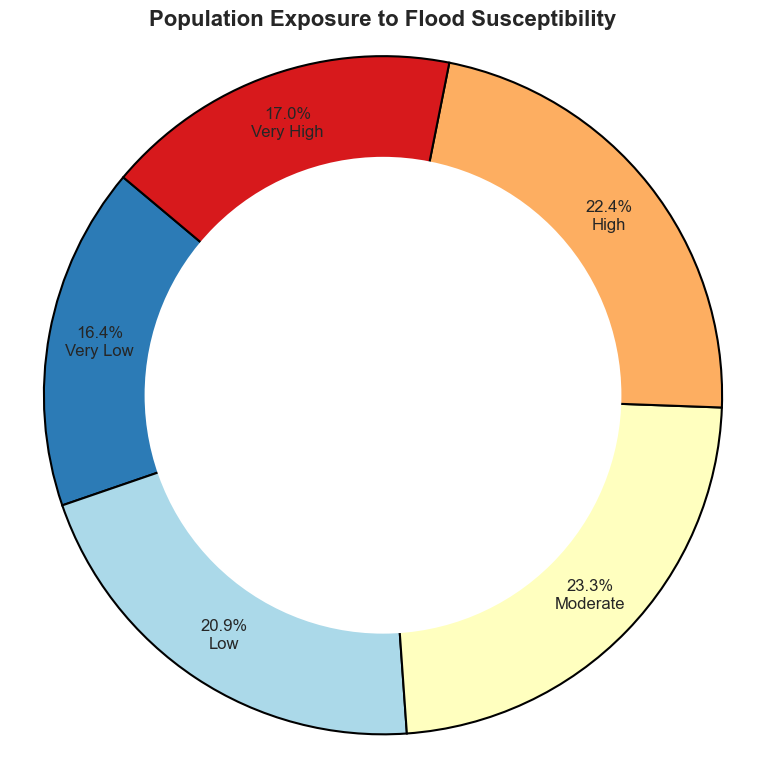

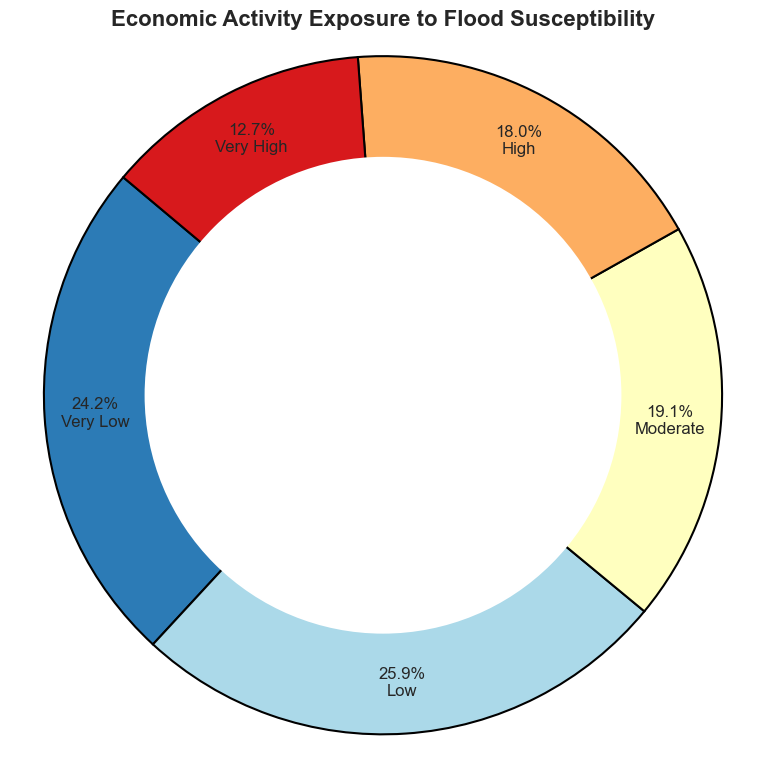

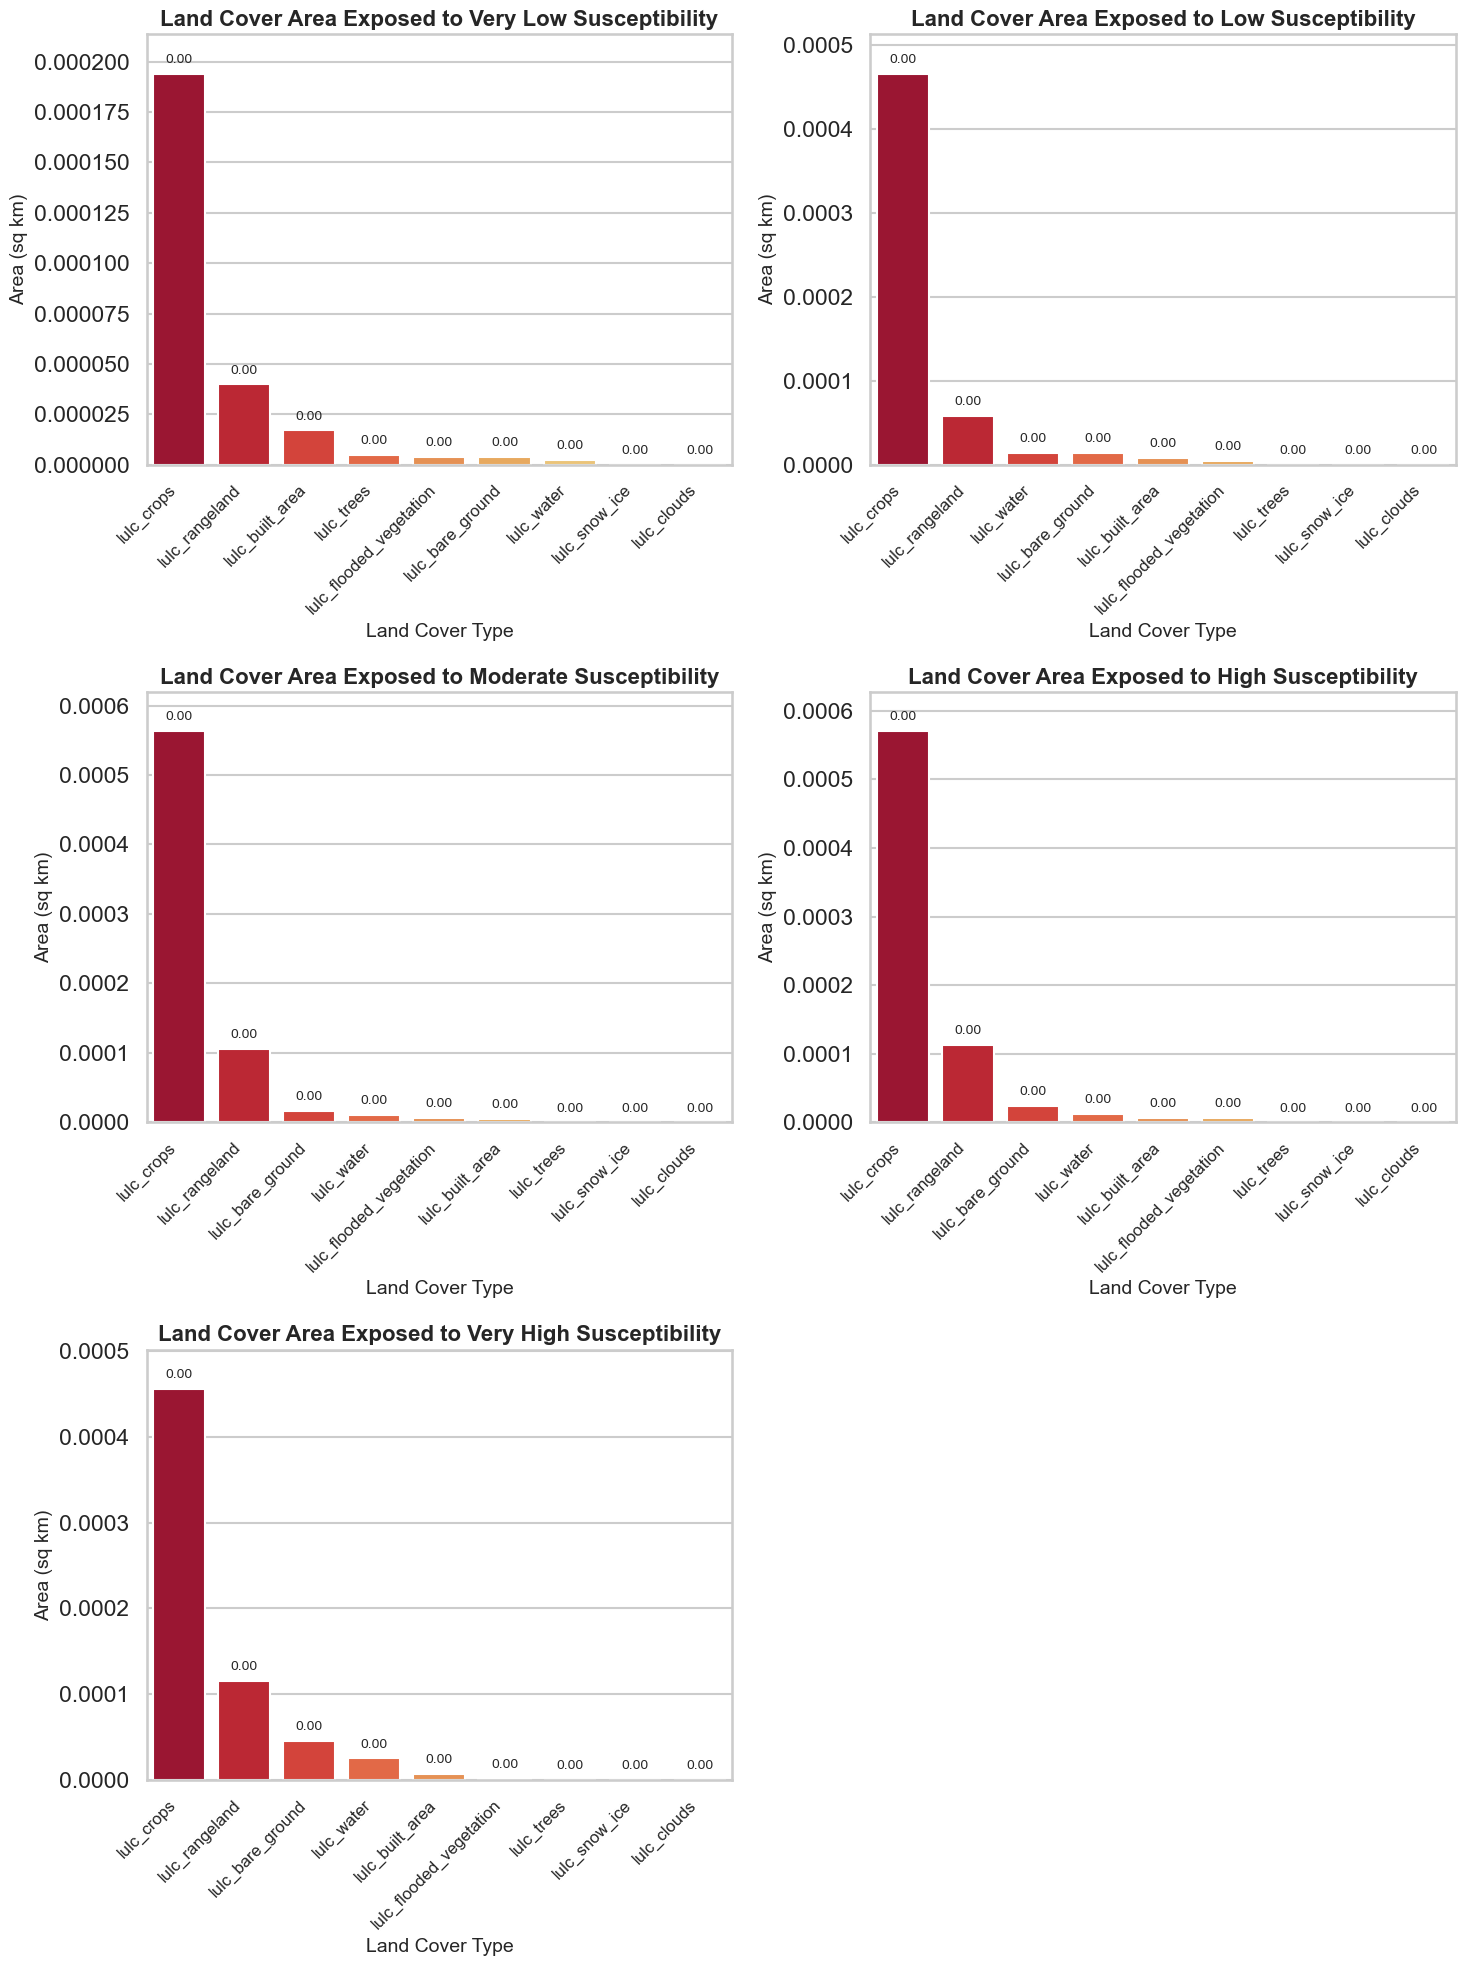

In [9]:
visualize_exposure(exposure_df, export=False)


## Export Layers

In [12]:

def export_layers(aoi, flood_layer, flood_class, flood_mapped, susceptibility_layer, susceptibility_category_layer,
                  export_flood_layer=True, export_flood_class=True, export_flood_mapped=True,
                  export_susceptibility_layer=True, export_susceptibility_category_layer=True):
    """
    Export specified layers to Google Drive.

    Parameters:
    aoi (ee.Geometry): Area of Interest.
    flood_binary (ee.Image): Flood binary layer.
    flood_class (ee.Image): Flood class layer.
    flood_mapped (ee.Image): Flood mapped layer.
    susceptibility_layer (ee.Image): Susceptibility layer.
    susceptibility_category_layer (ee.Image): Susceptibility category layer.
    export_flood_binary (bool): Flag to export flood binary layer.
    export_flood_class (bool): Flag to export flood class layer.
    export_flood_mapped (bool): Flag to export flood mapped layer.
    export_susceptibility_layer (bool): Flag to export susceptibility layer.
    export_susceptibility_category_layer (bool): Flag to export susceptibility category layer.
    """

    tasks = []
    aoi = aoi.geometry()
    if export_flood_layer:
        flood_binary_task = ee.batch.Export.image.toDrive(
            image=flood_layer,
            description=f'{city}_flood_mask_layer',
            folder='FMSE',
            scale=10,
            region=aoi,
            maxPixels=1e13
        )
        flood_binary_task.start()
        tasks.append(flood_binary_task)

    if export_flood_class:
        flood_class_task = ee.batch.Export.image.toDrive(
            image=flood_class,
            description=f'{city}_flood_class_layer',
            folder='FMSE',
            scale=10,
            region=aoi,
            maxPixels=1e13
        )
        flood_class_task.start()
        tasks.append(flood_class_task)

    if export_flood_mapped:
        flood_mapped_task = ee.batch.Export.image.toDrive(
            image=flood_mapped,
            description=f'{city}_flood_mapped_layer',
            folder='FMSE',
            scale=10,
            region=aoi,
            maxPixels=1e13
        )
        flood_mapped_task.start()
        tasks.append(flood_mapped_task)

    if export_susceptibility_layer:
        susceptibility_task = ee.batch.Export.image.toDrive(
            image=susceptibility_layer,
            description=f'{city}_flood_susceptibility_layer',
            folder='FMSE',
            scale=30,
            region=aoi,
            maxPixels=1e13
        )
        susceptibility_task.start()
        tasks.append(susceptibility_task)

    if export_susceptibility_category_layer:
        susceptibility_category_task = ee.batch.Export.image.toDrive(
            image=susceptibility_category_layer,
            description=f'{city}_flood_susceptibility_category_layer',
            folder='FMSE',
            scale=30,
            region=aoi,
            maxPixels=1e13
        )
        susceptibility_category_task.start()
        tasks.append(susceptibility_category_task)

    def monitor_tasks(tasks):
        while any([task.status()['state'] in ['READY', 'RUNNING'] for task in tasks]):
            for task in tasks:
                status = task.status()
                description = status['description']
                state = status['state']
                print(f'Task {description} is {state}')
            time.sleep(30)  # Check every 30 seconds

    # Monitor the export tasks
    monitor_tasks(tasks)

export_layers(city_shp, 
              flood_layer, flood_class, flood_binary, flood_susceptibility_prob, sus_catagory,
               export_flood_layer=True, 
               export_flood_class=True, 
               export_flood_mapped=True,
               export_susceptibility_layer=True, 
               export_susceptibility_category_layer=True)


Task Sylhet_flood_mask_layer is RUNNING
Task Sylhet_flood_class_layer is RUNNING
Task Sylhet_flood_mapped_layer is RUNNING
Task Sylhet_flood_susceptibility_layer is RUNNING
Task Sylhet_flood_susceptibility_category_layer is READY
Task Sylhet_flood_mask_layer is RUNNING
Task Sylhet_flood_class_layer is RUNNING
Task Sylhet_flood_mapped_layer is RUNNING
Task Sylhet_flood_susceptibility_layer is RUNNING
Task Sylhet_flood_susceptibility_category_layer is RUNNING
Task Sylhet_flood_mask_layer is RUNNING
Task Sylhet_flood_class_layer is RUNNING
Task Sylhet_flood_mapped_layer is RUNNING
Task Sylhet_flood_susceptibility_layer is RUNNING
Task Sylhet_flood_susceptibility_category_layer is RUNNING
Task Sylhet_flood_mask_layer is RUNNING
Task Sylhet_flood_class_layer is RUNNING
Task Sylhet_flood_mapped_layer is RUNNING
Task Sylhet_flood_susceptibility_layer is RUNNING
Task Sylhet_flood_susceptibility_category_layer is RUNNING
Task Sylhet_flood_mask_layer is RUNNING
Task Sylhet_flood_class_layer is R